## [1] Import Libraries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import rasterio as rio
import pickle
import warnings
warnings.filterwarnings("ignore")

## [2] Calculate Baseline Tensile Strengths

This section calculates the tensile strength as a function of the surface temperature model, averaging time period, and rate factor parameterization without considering velocity error. This provides a baseline that we use for plotting the black dots in Figure 4. 

In [2]:
##### Baseline Tensile Strength Estimate Variations

# Directories with the strain rates
strain_dir_w = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\StrainRate\\"
strain_dir_e = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\StrainRateNE\\"
# Directory with the surface temperatures
temp_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\"
# Directory with the crevasse/no crevasse observations
crev_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\RevisedTrainingData\\"
# Directory with the boundaries of the test data that we will withold from training
test_dir =  "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\TestSet\\"

# Baseline (optimal) strain rate map to sue
strain_experiments = "Exp18"
# Baseline (optimal) velocity data source to use
velocity_maps = "MAvg"
# List of temperature averaging options to test
temp_maps = ["Annual", "DJF", "JJA"]
# List of temperature models to test
temp_model = ["RACMO", "MAR", "CARRA"]
# List of rate factor parameterizations to try, 0 = Cuffey & Patterson, 1 = Hooke
viscosity = [0, 1]
# List of crevasse maps
crev_maps = ["Riley", "IE"]

# Cuffey and Patterson Constants for Ice Viscosity Model
A_star = 3.5e-25        # Pa^-3s^-1
T_start = 263.0         # K
R = 8.314               # J mol^-1 K^-1
Qc = 60e3               # J mol^-1
Qc2 = 115e3             # J mol^-1
n = 3.

# Hooke Viscosity Model Parameters
B0 = 2.207     # Pa year^-1
T0 = 3155                 # K
C = 0.16612               # K^k
T_r = 273.39              # K
k_coeff = 1.17

# Probability axis
axis = np.arange(0,350000,100).reshape(-1,1)

count = 0

# Save the optimal discrmination threshold probability
threshold = np.zeros((len(crev_maps),len(temp_maps),len(temp_model),len(viscosity)))
# Save the optimized tensile strength
tensile_strength = np.zeros((len(crev_maps),len(temp_maps),len(temp_model),len(viscosity)))
# Save the full probability of fracture curve for each model
prob_curve = np.zeros((len(axis),len(temp_maps)*len(temp_model)*len(viscosity)*len(crev_maps)))
for q in crev_maps:
    for i in temp_maps:
        for j in temp_model:
            for k in viscosity:
            
                # Strain files for west coast
                eXX_file_w = strain_dir_w+strain_experiments+"_eXX_"+velocity_maps+".tif"
                eYY_file_w = strain_dir_w+strain_experiments+"_eYY_"+velocity_maps+".tif"
                eXY_file_w = strain_dir_w+strain_experiments+"_eXY_"+velocity_maps+".tif"

                # Read in all three components of the strain rate
                dataset = rio.open(eXX_file_w)
                eXX_w = dataset.read(1)
                dataset.close()
                dataset = rio.open(eYY_file_w)
                eYY_w = dataset.read(1)
                dataset.close()
                dataset = rio.open(eXY_file_w)
                eXY_w = dataset.read(1)
                dataset.close()

                # Strain files for east coast
                eXX_file_e = strain_dir_e+strain_experiments+"_eXX_"+velocity_maps+".tif"
                eYY_file_e = strain_dir_e+strain_experiments+"_eYY_"+velocity_maps+".tif"
                eXY_file_e = strain_dir_e+strain_experiments+"_eXY_"+velocity_maps+".tif"

                # Read in all three components of the strain rate
                dataset = rio.open(eXX_file_e)
                eXX_e = dataset.read(1)
                dataset.close()
                dataset = rio.open(eYY_file_e)
                eYY_e = dataset.read(1)
                dataset.close()
                dataset = rio.open(eXY_file_e)
                eXY_e = dataset.read(1)
                dataset.close()
            
                temp_file_w = temp_dir+j+"Training\\Clip_"+j+i+"_250m.tif"
                temp_file_e = temp_dir+j+"Training\\NE_"+j+i+"_250m.tif"
                crev_file_w = crev_dir+"CrevasseMask_250m_"+q+".tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_250m_"+q+".tif"
                nocrev_file_w = crev_dir+"NoCrevasseMask_250m_"+q+".tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_250m_"+q+".tif"
                test_file_w = test_dir+"W_TestSet_250m.tif"
                test_file_e = test_dir+"NE_TestSet_250m.tif"
                    
                # Load data for the west coast temperature filed
                dataset = rio.open(temp_file_w)
                temp_w = dataset.read(1)
                dataset.close()
                # Load crevasse mask for west coast
                dataset = rio.open(crev_file_w)
                crevasses_w = dataset.read(1)
                dataset.close()
                # Load no crevasse mask for west coast
                dataset = rio.open(nocrev_file_w)
                no_crevasses_w = dataset.read(1)
                dataset.close()
                # Load test set for west coast
                dataset = rio.open(test_file_w)
                test_w = dataset.read(1)
                dataset.close()

                # Load data for the east coast temperature field
                dataset = rio.open(temp_file_e)
                temp_e = dataset.read(1)
                dataset.close()
                # Load crevasse mask for east coast
                dataset = rio.open(crev_file_e)
                crevasses_e = dataset.read(1)
                dataset.close()
                # Load no crevasse mask for east coast
                dataset = rio.open(nocrev_file_e)
                no_crevasses_e = dataset.read(1)
                dataset.close()
                # Load test set for east coast
                dataset = rio.open(test_file_e)
                test_e = dataset.read(1)
                dataset.close()

                 # File paths for the appropriate temperature fields, crevassse observations, and test set mask
                crevasses_w = np.matrix.flatten(crevasses_w.astype("float64"))
                crevasses_e = np.matrix.flatten(crevasses_e.astype("float64"))
                crevasses = np.concatenate((crevasses_w, crevasses_e), axis=0)
                no_crevasses_w = np.matrix.flatten(no_crevasses_w.astype("float64"))
                no_crevasses_e = np.matrix.flatten(no_crevasses_e.astype("float64"))
                no_crevasses = np.concatenate((no_crevasses_w, no_crevasses_e), axis=0)
                test_w = np.matrix.flatten(test_w.astype("float64"))
                test_e = np.matrix.flatten(test_e.astype("float64"))
                test = np.concatenate((test_w, test_e), axis=0)

                # Combine flattened strain rate matrices for both regions (east and west)
                eXX_comb = np.concatenate((np.matrix.flatten(eXX_w), np.matrix.flatten(eXX_e)), axis=0)
                eXY_comb = np.concatenate((np.matrix.flatten(eXY_w), np.matrix.flatten(eXY_e)), axis=0)
                eYY_comb = np.concatenate((np.matrix.flatten(eYY_w), np.matrix.flatten(eYY_e)), axis=0)

                # Combine flattened temperature information for both regions (east and west)
                temp_comb = np.concatenate((np.matrix.flatten(temp_w), np.matrix.flatten(temp_e)), axis=0)
    
                # Extract strain rates in crevassed and uncrevassed regions
                eXX_crev = eXX_comb[crevasses == 1]
                eXX_nocrev = eXX_comb[no_crevasses == 1]
                eXY_crev = eXY_comb[crevasses == 1]
                eXY_nocrev = eXY_comb[no_crevasses == 1]
                eYY_crev = eYY_comb[crevasses == 1]
                eYY_nocrev = eYY_comb[no_crevasses == 1]
    
                # Extract temperatures for crevassed and uncrevassed regions
                temp_crev = temp_comb[crevasses == 1]
                temp_nocrev = temp_comb[no_crevasses == 1]
    
                # Extract test set for crevassed and uncrevassed regions
                test_crev = test[crevasses == 1]
                test_nocrev = test[no_crevasses == 1]
    
                # Merge into a single vectors for all variables of interest
                eXX = np.concatenate((eXX_crev, eXX_nocrev), axis=0)
                eXY = np.concatenate((eXY_crev, eXY_nocrev), axis=0)
                eYY = np.concatenate((eYY_crev, eYY_nocrev), axis=0)
                temp = np.concatenate((temp_crev,  temp_nocrev), axis=0)
                test_set = np.concatenate((test_crev,  test_nocrev), axis=0)

                # Convert temperature field to degrees Kelvin
                temp = temp + 273.15

                if k == 0:   # Cuffey and Patterson rate factor
                    # Calculate creep coefficient with temperature dependence of activation energy
                    A = np.zeros(temp.shape)
                    for p in range(0,temp.shape[0]):
                        if temp[p] > 273.15:
                            temp[p] = 273.15
                            A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                        elif temp[p] > 263.0:
                            A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                        else:
                            A[p] = A_star*np.exp((-Qc/R)*((1/temp[p]) - (1/T_start)))
                    # Convert strain rates from 1/yr to 1/s
                    eXX_s = eXX*(1/(60*60*24*365))
                    eXY_s = eXY*(1/(60*60*24*365))
                    eYY_s = eYY*(1/(60*60*24*365))
                    #Calculate effective stress
                    eE = np.sqrt(0.5*(eXX_s**2 + eYY_s**2 + (-eXX_s - eYY_s)**2) + eXY_s**2)
                    # Calculate deviatoric stress at surface
                    tau_xx = (A**(-1/n))*(eE**((1-n)/n))*eXX_s
                    tau_yy = (A**(-1/n))*(eE**((1-n)/n))*eYY_s
                    tau_xy = (A**(-1/n))*(eE**((1-n)/n))*eXY_s  
                elif k == 1:   # Hooke rate factor
                    B = np.zeros(temp.shape)
                    for p in range(0,temp.shape[0]):
                        if temp[p] > 273.15:
                            temp[p] = 273.15
                        B[p] = B0*np.exp((T0/temp[p]) - (C/np.power(T_r - temp[p], k_coeff)))
                    #Calculate effective stress
                    eE = np.sqrt(0.5*(eXX**2 + eYY**2 + (-eXX - eYY)**2) + eXY**2)
                    # Calculate deviatoric stress at surface
                    tau_xx = B*(eE**((1-n)/n))*eXX
                    tau_yy = B*(eE**((1-n)/n))*eYY
                    tau_xy = B*(eE**((1-n)/n))*eXY

                # Calculate full Cauchy stress at surface
                sigma_xx = 2.*tau_xx + tau_yy
                sigma_yy = 2.*tau_yy + tau_xx
    
                # Calculate principal stresses
                sigma1 = 0.5*(sigma_xx + sigma_yy) + np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
                sigma2 = 0.5*(sigma_xx + sigma_yy) - np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
    
                # Von Mises Stress over whole area of interest
                sigmaV = np.sqrt(sigma1**2 - sigma1*sigma2 + sigma2**2)
    
                # Make the label set
                label = np.concatenate((np.ones(temp_crev.shape), np.zeros(temp_nocrev.shape)), axis=0)
    
                # Remove regions of pure compression, because we will automatically predict no fracture there
                stress = sigmaV[sigma1 > 0.]
                test_set = test_set[sigma1 > 0.]
                compression_label = label[sigma1 <= 0.]
                label = label[sigma1 > 0.]

                # Test-train split using the pre-defined test set
                stress_train,stress_test,label_train,label_test=train_test_split(stress.reshape(-1,1),label,stratify=test_set)
    
                # Instantiate and train logistic regression model, accounting for class imbalance
                regress = LogisticRegression(class_weight="balanced")
                regress.fit(stress_train,label_train)

                a = crev_maps.index(q)
                b = temp_maps.index(i)
                c = temp_model.index(j)
                d = viscosity.index(k)
    
                print(q,"-",i,"-",j,"-",k)
    
                # Find the optimal discrimination threshold
                prob = regress.predict_proba(stress_train)
                precision, recall, thresholds = metrics.precision_recall_curve(label_train, prob[:,1])
                # convert to f score
                fscore = (2 * precision * recall) / (precision + recall)
                fscore[np.isnan(fscore)] = 0
                # locate the index of the largest f score
                ix = np.argmax(fscore)
                print('Best Threshold=%.3f' % (thresholds[ix]))
    
                threshold[a,b,c,d] = thresholds[ix]

                # Calculate crevasse predictions on test set with optimized discrimination threshold
                prob = regress.predict_proba(stress_test)
                y_hat = np.zeros(prob[:,1].shape)
                y_hat[prob[:,1] >= thresholds[ix]] = 1
                # Reincorporate regions of pure compression which we automatically assign to be no crevasse
                y_hat = np.concatenate((y_hat, np.zeros(compression_label.shape)), axis=0)
                y_test = np.concatenate((label_test, compression_label), axis=0)
                fscore = metrics.f1_score(y_test, y_hat, average="weighted")
                print('F-Score=%.3f' % (fscore))
    
                # Calculate the tensile strength at the optimal threshold
                probability = regress.predict_proba(axis)
                prob_curve[:,count] = probability[:,1]
                ind = np.argmin(np.abs(probability[:,1] - thresholds[ix]))
                tensile_strength[a,b,c,d] = axis[ind,0]
                print("Tensile Strength: "+str(axis[ind,0]/1000.)+" kPa")
            
                count = count + 1

Riley - Annual - RACMO - 0
Best Threshold=0.352
F-Score=0.857
Tensile Strength: 109.9 kPa
Riley - Annual - RACMO - 1
Best Threshold=0.364
F-Score=0.857
Tensile Strength: 94.6 kPa
Riley - Annual - MAR - 0
Best Threshold=0.350
F-Score=0.858
Tensile Strength: 110.0 kPa
Riley - Annual - MAR - 1
Best Threshold=0.358
F-Score=0.854
Tensile Strength: 94.5 kPa
Riley - Annual - CARRA - 0
Best Threshold=0.368
F-Score=0.856
Tensile Strength: 117.3 kPa
Riley - Annual - CARRA - 1
Best Threshold=0.371
F-Score=0.859
Tensile Strength: 101.9 kPa
Riley - DJF - RACMO - 0
Best Threshold=0.366
F-Score=0.861
Tensile Strength: 165.5 kPa
Riley - DJF - RACMO - 1
Best Threshold=0.353
F-Score=0.858
Tensile Strength: 158.9 kPa
Riley - DJF - MAR - 0
Best Threshold=0.357
F-Score=0.859
Tensile Strength: 167.6 kPa
Riley - DJF - MAR - 1
Best Threshold=0.362
F-Score=0.859
Tensile Strength: 163.9 kPa
Riley - DJF - CARRA - 0
Best Threshold=0.371
F-Score=0.858
Tensile Strength: 170.6 kPa
Riley - DJF - CARRA - 1
Best Thresh

## [3] Calculate Range of Tensile Strengths (with Velocity Error) 

We now run the same set of experiments using the 20 perturbed velocity maps to quantify how errors in the initial velocity measurments propagate into strain rate errors, stress errors, and by extension, uncertainty in the tensile strength of ice slabs. 

In [3]:
# Directories with the strain rates - note that these now need to include velocity perturbations
strain_dir_w = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\ErrorMaps\\"
strain_dir_e = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\ErrorMaps\\NE\\"
# Directory with the surface temperatures
temp_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\"
# Directory with the crevasse/no crevasse observations
crev_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\RevisedTrainingData\\"
# Directory with the boundaries of the test data that we will withold from training
test_dir =  "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\TestSet\\"

# List of velocity perturbation experiment names
strain_experiments = ["Exp0", "Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6", "Exp7","Exp8", "Exp9"]
# List of covariance structure options
correlation = ["Gaussian", "Exponential"]
# List of temperature averaging options to test
temp_maps = ["Annual", "DJF", "JJA"]
# List of temperatur models to test
temp_model = ["RACMO", "MAR", "CARRA"]
# List of rate factor parameterizations to try, 0 = Cuffey & Patterson, 1 = Hooke
viscosity = [0, 1]
# Different observational maps for training
crev_maps = ["Riley", "IE"]

# Cuffey and Patterson Constants for Ice Viscosity Model
A_star = 3.5e-25        # Pa^-3s^-1
T_start = 263.0         # K
R = 8.314               # J mol^-1 K^-1
Qc = 60e3               # J mol^-1
Qc2 = 115e3             # J mol^-1
n = 3.

# Hooke Viscosity Model Parameters
B0 = 2.207     # Pa year^-1
T0 = 3155                 # K
C = 0.16612               # K^k
T_r = 273.39              # K
k_coeff = 1.17

# Probability axis
axis = np.arange(0,350000,100).reshape(-1,1)

count = 0
# Save f1 score for each combination of parameters
f1_err = np.zeros((len(crev_maps),len(temp_maps),len(temp_model),len(viscosity),len(strain_experiments),len(correlation)))
# Save optimal probability threshold for each combination of parameters
threshold_err = np.zeros((len(crev_maps),len(temp_maps),len(temp_model),len(viscosity),len(strain_experiments),len(correlation)))
# Save estimated tensile strength score for each combination of parameters
tensile_strength_err = np.zeros((len(crev_maps),len(temp_maps),len(temp_model),len(viscosity),len(strain_experiments),len(correlation)))
# Save fracture probability as a function f stress for each combination of parameters
prob_curve_err = np.zeros((len(axis),len(temp_maps)*len(temp_model)*len(viscosity)*len(correlation)*len(strain_experiments)*len(crev_maps)))

for q in crev_maps:
    for i in temp_maps:
        for j in temp_model:
            for k in viscosity:
                for m in strain_experiments:
                    for w in correlation:

                        # Strain files for west coast
                        eXX_file_w = strain_dir_w+m+"_eXX_"+w+".tif"
                        eYY_file_w = strain_dir_w+m+"_eYY_"+w+".tif"
                        eXY_file_w = strain_dir_w+m+"_eXY_"+w+".tif"

                        # Read in all three components of the strain rate
                        dataset = rio.open(eXX_file_w)
                        eXX_w = dataset.read(1)
                        dataset.close()
                        dataset = rio.open(eYY_file_w)
                        eYY_w = dataset.read(1)
                        dataset.close()
                        dataset = rio.open(eXY_file_w)
                        eXY_w = dataset.read(1)
                        dataset.close()

                        # Strain files for east coast
                        eXX_file_e = strain_dir_e+m+"_eXX_"+w+".tif"
                        eYY_file_e = strain_dir_e+m+"_eYY_"+w+".tif"
                        eXY_file_e = strain_dir_e+m+"_eXY_"+w+".tif"

                        # Read in all three components of the strain rate
                        dataset = rio.open(eXX_file_e)
                        eXX_e = dataset.read(1)
                        dataset.close()
                        dataset = rio.open(eYY_file_e)
                        eYY_e = dataset.read(1)
                        dataset.close()
                        dataset = rio.open(eXY_file_e)
                        eXY_e = dataset.read(1)
                        dataset.close()

                        # File paths for the appropriate temperature fields, crevassse observations, and test set mask
                        temp_file_w = temp_dir+j+"Training\\Clip_"+j+i+"_250m.tif"
                        temp_file_e = temp_dir+j+"Training\\NE_"+j+i+"_250m.tif"
                        crev_file_w = crev_dir+"CrevasseMask_250m_"+q+".tif"
                        crev_file_e = crev_dir+"NE_CrevasseMask_250m_"+q+".tif"
                        nocrev_file_w = crev_dir+"NoCrevasseMask_250m_"+q+".tif"
                        nocrev_file_e = crev_dir+"NE_NoCrevasseMask_250m_"+q+".tif"
                        test_file_w = test_dir+"W_TestSet_250m.tif"
                        test_file_e = test_dir+"NE_TestSet_250m.tif"
                    
                         # Load data for the west coast temperature field
                        dataset = rio.open(temp_file_w)
                        temp_w = dataset.read(1)
                        dataset.close()
                        # Load crevasse mask for west coast
                        dataset = rio.open(crev_file_w)
                        crevasses_w = dataset.read(1)
                        dataset.close()
                        # Load no crevasse mask for west coast
                        dataset = rio.open(nocrev_file_w)
                        no_crevasses_w = dataset.read(1)
                        dataset.close()
                        # Load test set for west coast
                        dataset = rio.open(test_file_w)
                        test_w = dataset.read(1)
                        dataset.close()

                        # Load data for the east coast temperature field
                        dataset = rio.open(temp_file_e)
                        temp_e = dataset.read(1)
                        dataset.close()
                        # Load crevasse mask for east coast
                        dataset = rio.open(crev_file_e)
                        crevasses_e = dataset.read(1)
                        dataset.close()
                        # Load no crevasse mask for east coast
                        dataset = rio.open(nocrev_file_e)
                        no_crevasses_e = dataset.read(1)
                        dataset.close()
                        # Load test set for east coast
                        dataset = rio.open(test_file_e)
                        test_e = dataset.read(1)
                        dataset.close()

                        # Flatten data from a 2D map into a 1D vector for all datasets, then merge data from east and west training areas 
                        # into a single vector for each variable
                        crevasses_w = np.matrix.flatten(crevasses_w.astype("float64"))
                        crevasses_e = np.matrix.flatten(crevasses_e.astype("float64"))
                        crevasses = np.concatenate((crevasses_w, crevasses_e), axis=0)
                        no_crevasses_w = np.matrix.flatten(no_crevasses_w.astype("float64"))
                        no_crevasses_e = np.matrix.flatten(no_crevasses_e.astype("float64"))
                        no_crevasses = np.concatenate((no_crevasses_w, no_crevasses_e), axis=0)
                        test_w = np.matrix.flatten(test_w.astype("float64"))
                        test_e = np.matrix.flatten(test_e.astype("float64"))
                        test = np.concatenate((test_w, test_e), axis=0)

                        # Combine flattened strain rate matrices for both regions (east and west)
                        eXX_comb = np.concatenate((np.matrix.flatten(eXX_w), np.matrix.flatten(eXX_e)), axis=0)
                        eXY_comb = np.concatenate((np.matrix.flatten(eXY_w), np.matrix.flatten(eXY_e)), axis=0)
                        eYY_comb = np.concatenate((np.matrix.flatten(eYY_w), np.matrix.flatten(eYY_e)), axis=0)

                        # Combine flattened temperature information for both regions (east and west)
                        temp_comb = np.concatenate((np.matrix.flatten(temp_w), np.matrix.flatten(temp_e)), axis=0)

                        # Extract strain rates in crevassed and uncrevassed regions
                        eXX_crev = eXX_comb[crevasses == 1]
                        eXX_nocrev = eXX_comb[no_crevasses == 1]
                        eXY_crev = eXY_comb[crevasses == 1]
                        eXY_nocrev = eXY_comb[no_crevasses == 1]
                        eYY_crev = eYY_comb[crevasses == 1]
                        eYY_nocrev = eYY_comb[no_crevasses == 1]

                        # Extract temperatures for crevassed and uncrevassed regions
                        temp_crev = temp_comb[crevasses == 1]
                        temp_nocrev = temp_comb[no_crevasses == 1]

                        # Extract test set for crevassed and uncrevassed regions
                        test_crev = test[crevasses == 1]
                        test_nocrev = test[no_crevasses == 1]

                        # Merge into a single vectors for all variables of interest
                        eXX = np.concatenate((eXX_crev, eXX_nocrev), axis=0)
                        eXY = np.concatenate((eXY_crev, eXY_nocrev), axis=0)
                        eYY = np.concatenate((eYY_crev, eYY_nocrev), axis=0)
                        temp = np.concatenate((temp_crev,  temp_nocrev), axis=0)
                        test_set = np.concatenate((test_crev,  test_nocrev), axis=0)

                        # Convert temperature field to degrees Kelvin
                        temp = temp + 273.15

                        if k == 0:  # Cuffey & Patterson
                            # Calculate creep coefficient with temperature dependence of activation energy
                            A = np.zeros(temp.shape)
                            for p in range(0,temp.shape[0]):
                                if temp[p] > 273.15:
                                    temp[p] = 273.15
                                    A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                                elif temp[p] > 263.0:
                                    A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                                else:
                                    A[p] = A_star*np.exp((-Qc/R)*((1/temp[p]) - (1/T_start)))
                            # Convert strain rates from 1/yr to 1/s
                            eXX_s = eXX*(1/(60*60*24*365))
                            eXY_s = eXY*(1/(60*60*24*365))
                            eYY_s = eYY*(1/(60*60*24*365))
                            #Calculate effective stress
                            eE = np.sqrt(0.5*(eXX_s**2 + eYY_s**2 + (-eXX_s - eYY_s)**2) + eXY_s**2)
                            # Calculate deviatoric stress at surface
                            tau_xx = (A**(-1/n))*(eE**((1-n)/n))*eXX_s
                            tau_yy = (A**(-1/n))*(eE**((1-n)/n))*eYY_s
                            tau_xy = (A**(-1/n))*(eE**((1-n)/n))*eXY_s  
                        elif k == 1:    # Hooke
                            B = np.zeros(temp.shape)
                            for p in range(0,temp.shape[0]):
                                    if temp[p] > 273.15:
                                        temp[p] = 273.15
                                    B[p] = B0*np.exp((T0/temp[p]) - (C/np.power(T_r - temp[p], k_coeff)))
                            #Calculate effective stress
                            eE = np.sqrt(0.5*(eXX**2 + eYY**2 + (-eXX - eYY)**2) + eXY**2)
                            # Calculate deviatoric stress at surface
                            tau_xx = B*(eE**((1-n)/n))*eXX
                            tau_yy = B*(eE**((1-n)/n))*eYY
                            tau_xy = B*(eE**((1-n)/n))*eXY

                        # Calculate full Cauchy stress at surface
                        sigma_xx = 2.*tau_xx + tau_yy
                        sigma_yy = 2.*tau_yy + tau_xx

                        # Calculate principal stresses
                        sigma1 = 0.5*(sigma_xx + sigma_yy) + np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
                        sigma2 = 0.5*(sigma_xx + sigma_yy) - np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)

                        # Von Mises Stress over whole area of interest
                        sigmaV = np.sqrt(sigma1**2 - sigma1*sigma2 + sigma2**2)
        
                        # Make the label set
                        label = np.concatenate((np.ones(temp_crev.shape), np.zeros(temp_nocrev.shape)), axis=0)

                        # Remove regions of pure compression, because we will automatically predict no fracture there
                        stress = sigmaV[sigma1 > 0.]
                        test_set = test_set[sigma1 > 0.]
                        compression_label = label[sigma1 <= 0.]
                        label = label[sigma1 > 0.]

                        # Test-train split, based on pre-defined test regions
                        stress_train,stress_test,label_train,label_test=train_test_split(stress.reshape(-1,1),label,stratify=test_set)

                        # Instantiate and train the model
                        regress = LogisticRegression(class_weight="balanced")
                        regress.fit(stress_train,label_train)

                        a = crev_maps.index(q)
                        b = temp_maps.index(i)
                        c = temp_model.index(j)
                        d = viscosity.index(k)
                        e = strain_experiments.index(m)
                        f = correlation.index(w)

                        print(q, "-", i,"-",j,"-",k,"-",m,"-",w)

                        # Calculate the optimal discrimination threshold on the test set
                        prob = regress.predict_proba(stress_train)
                        precision, recall, thresholds = metrics.precision_recall_curve(label_train, prob[:,1])
                        # convert to f score
                        fscore = (2 * precision * recall) / (precision + recall)
                        fscore[np.isnan(fscore)] = 0
                        # locate the index of the largest f score
                        ix = np.argmax(fscore)
                        print('Best Threshold=%.3f' % (thresholds[ix]))

                        threshold_err[a,b,c,d,e,f] = thresholds[ix]

                        # Calculate crevasse predictions on test set with optimized discrimination threshold
                        prob = regress.predict_proba(stress_test)
                        y_hat = np.zeros(prob[:,1].shape)
                        y_hat[prob[:,1] >= thresholds[ix]] = 1
                        # Reincorporate regions of pure compression which we automatically assign to be no crevasse
                        y_hat = np.concatenate((y_hat, np.zeros(compression_label.shape)), axis=0)
                        y_test = np.concatenate((label_test, compression_label), axis=0)
                        fscore = metrics.f1_score(y_test, y_hat, average="weighted")
                        print('F-Score=%.3f' % (fscore))

                        # Save the f1 score
                        f1_err[a,b,c,d,e,f] = fscore

                        # Generate and save the probability as a function of stress curve for this model
                        probability = regress.predict_proba(axis)
                        prob_curve_err[:,count] = probability[:,1]
                        ind = np.argmin(np.abs(probability[:,1] - thresholds[ix]))
                        tensile_strength_err[a,b,c,d,e,f] = axis[ind,0]
                        print("Tensile Strength: "+str(axis[ind,0]/1000.)+" kPa")
        
                        count = count + 1

Riley - Annual - RACMO - 0 - Exp0 - Gaussian
Best Threshold=0.355
F-Score=0.857
Tensile Strength: 110.4 kPa
Riley - Annual - RACMO - 0 - Exp0 - Exponential
Best Threshold=0.351
F-Score=0.855
Tensile Strength: 110.5 kPa
Riley - Annual - RACMO - 0 - Exp1 - Gaussian
Best Threshold=0.351
F-Score=0.855
Tensile Strength: 110.2 kPa
Riley - Annual - RACMO - 0 - Exp1 - Exponential
Best Threshold=0.365
F-Score=0.856
Tensile Strength: 111.2 kPa
Riley - Annual - RACMO - 0 - Exp2 - Gaussian
Best Threshold=0.371
F-Score=0.860
Tensile Strength: 111.8 kPa
Riley - Annual - RACMO - 0 - Exp2 - Exponential
Best Threshold=0.382
F-Score=0.858
Tensile Strength: 113.1 kPa
Riley - Annual - RACMO - 0 - Exp3 - Gaussian
Best Threshold=0.364
F-Score=0.858
Tensile Strength: 111.3 kPa
Riley - Annual - RACMO - 0 - Exp3 - Exponential
Best Threshold=0.364
F-Score=0.854
Tensile Strength: 110.9 kPa
Riley - Annual - RACMO - 0 - Exp4 - Gaussian
Best Threshold=0.373
F-Score=0.856
Tensile Strength: 111.7 kPa
Riley - Annual -

## [3] Save Tensile Strength Results

Save both the baseline results without velocity perturbations and the models that quantify the impact of velocity uncertainty in a pickle file as a dictionary. 

In [4]:
# base_curves - baseline fracture/no fracture probability curves for each experiment
# base_thresh - baseline probability threshold for fracture discrimination for each experiment
# base_ts - baseline tensile strength for each experiment
# err_curves - fracture/no fracture probability curves for all 120 models that use perturbed velocity maps
# err_thresh - probability threshold for fracture discrimination for each of the 120 models from the perturbed velocity ensemble
# err_ts - tensile strength estimates for each of the 120 models from the perturbed velocity ensemble
# err_f1 - F1 score on test set for each of the 120 models from the perturbed velocity ensemble

results = {"base_curves": prob_curve, "base_thresh": threshold, "base_ts": tensile_strength, 
           "err_curves": prob_curve_err, "err_thresh": threshold_err, "err_ts": tensile_strength_err, "err_f1": f1_err}

with open('TensileStrengthResults_Final.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## [4] Plot Final Tensile Strength Comparison Plot

Code to reproduce Figure 5 in the main text. 

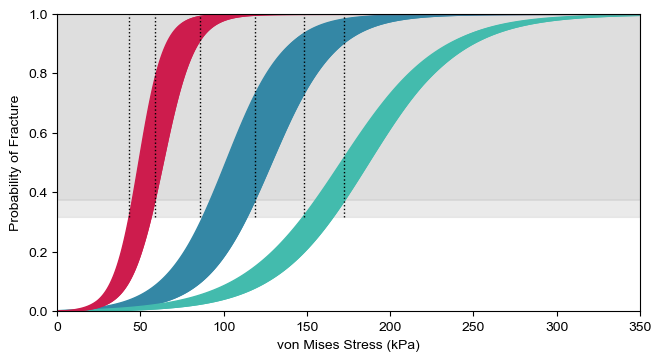

In [6]:
###### Make the nice plots

import pickle
with open('./data/TensileStrengthResults_Final.pickle', 'rb') as f:
    results = pickle.load(f)

axis = np.arange(0,350000,100).reshape(-1,1)
new_ax = np.ndarray.flatten(axis)

prob_curve_err = results['err_curves']

plt.close("all")
fig, ax = plt.subplots(layout="constrained", figsize=(6.5,3.5))
# Plot grey patches showing fractured zones
ax.fill_between(np.ndarray.flatten(axis)/1000, np.max(np.ndarray.flatten(results['base_thresh']))*np.ones(new_ax.shape), np.ones(new_ax.shape), 
                color="#BFBFBF", alpha=0.5)
ax.fill_between(np.ndarray.flatten(axis)/1000, np.min(np.ndarray.flatten(results['base_thresh']))*np.ones(new_ax.shape),  
                np.max(np.ndarray.flatten(results['base_thresh']))*np.ones(new_ax.shape), color="#D7D7D7", alpha=0.5)
# Plot individual fracture probaiblity curves with their width set by the range of solutions given different velocity perturbations
# Annual Mean
ax.fill_between(np.ndarray.flatten(axis)/1000, np.min(prob_curve_err[:,0:120],axis=1), np.max(prob_curve_err[:,0:120],axis=1), color="#3487A5")
ax.fill_between(np.ndarray.flatten(axis)/1000, np.min(prob_curve_err[:,0:120],axis=1), np.max(prob_curve_err[:,360:480],axis=1), color="#3487A5")
# Winter Mean
ax.fill_between(np.ndarray.flatten(axis)/1000, np.min(prob_curve_err[:,120:240],axis=1), np.max(prob_curve_err[:,120:240],axis=1), color="#43BBAD")
ax.fill_between(np.ndarray.flatten(axis)/1000, np.min(prob_curve_err[:,120:240],axis=1), np.max(prob_curve_err[:,480:600],axis=1), color="#43BBAD")
# Summer Mean
ax.fill_between(np.ndarray.flatten(axis)/1000, np.min(prob_curve_err[:,240:360],axis=1), np.max(prob_curve_err[:,240:360],axis=1), color="#CD1C4D")
ax.fill_between(np.ndarray.flatten(axis)/1000, np.min(prob_curve_err[:,240:360],axis=1), np.max(prob_curve_err[:,600:720],axis=1), color="#CD1C4D")
# Plot vertical dashed lines at the minimum and maximum tensile strength estimates
ax.vlines(np.min(np.ndarray.flatten(results['err_ts'][:,0,:,:,:]))/1000,
          np.min(np.ndarray.flatten(results['base_thresh'])), 1., "k", linestyle="dotted", linewidth=1)
ax.vlines(np.max(np.ndarray.flatten(results['err_ts'][:,0,:,:,:]))/1000,
          np.min(np.ndarray.flatten(results['base_thresh'])), 1., "k", linestyle="dotted", linewidth=1)
ax.vlines(np.min(np.ndarray.flatten(results['err_ts'][:,1,:,:,:]))/1000,
          np.min(np.ndarray.flatten(results['base_thresh'])), 1., "k", linestyle="dotted", linewidth=1)
ax.vlines(np.max(np.ndarray.flatten(results['err_ts'][:,1,:,:,:]))/1000,
          np.min(np.ndarray.flatten(results['base_thresh'])), 1., "k", linestyle="dotted", linewidth=1)
ax.vlines(np.min(np.ndarray.flatten(results['err_ts'][:,2,:,:,:]))/1000,
          np.min(np.ndarray.flatten(results['base_thresh'])), 1., "k", linestyle="dotted", linewidth=1)
ax.vlines(np.max(np.ndarray.flatten(results['err_ts'][:,2,:,:,:]))/1000,
          np.min(np.ndarray.flatten(results['base_thresh'])), 1., "k", linestyle="dotted", linewidth=1)
# Plot block dots at the baseline tensile strength for each scenario
#ax.scatter(np.ndarray.flatten(results['base_ts'])/1000, np.ndarray.flatten(results['base_thresh']), s=5, color="k")
plt.xlabel("von Mises Stress (kPa)", fontname="Arial")
plt.ylabel("Probability of Fracture", fontname="Arial");
plt.xlim((0,350))
plt.ylim((0,1))
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
plt.savefig("C:\\Users\\rtc84\OneDrive - Cornell University\\Research_FirstAuthor\\IceSlabCrevasses\\Revision\\RevisedFigures\\TensileStrength.svg")
plt.show()

## [5] Plot Distribution of Von Mises Stress

Demonstrates that the distribution has skew, which leads to the need to tune the discrimination threshold. This reproduces Figure S3. 

In [ ]:
import pickle
with open('./data/TensileStrengthResults_Final.pickle', 'rb') as f:
    results = pickle.load(f)

plt.rcParams.update({'font.size': 11})

axis = np.arange(0,350000,100).reshape(-1,1)
prob_curve_err = results['err_curves']

sigma_v_crev = np.sqrt(sigma1_crev_clean**2 - sigma1_crev_clean*sigma2_crev_clean + sigma2_crev_clean**2)
sigma_v_nocrev = np.sqrt(sigma1_nocrev_clean**2 - sigma1_nocrev_clean*sigma2_nocrev_clean + sigma2_nocrev_clean**2)

bins = np.arange(0,np.max(sigma_v_crev),1000)
p_pos = np.zeros(bins.shape)
p_neg = np.zeros(bins.shape)
for i in range(bins.shape[0]-1):
    pos_count = sigma_v_crev[np.logical_and(sigma_v_crev >= bins[i], sigma_v_crev < bins[i+1])].shape[0]
    neg_count = sigma_v_nocrev[np.logical_and(sigma_v_nocrev >= bins[i], sigma_v_nocrev < bins[i+1])].shape[0]
    if pos_count + neg_count > 0:
        p_pos[i] = pos_count/(pos_count + neg_count)
        p_neg[i] = neg_count/(pos_count + neg_count)


truth = np.invert(np.logical_and(p_pos == 0, p_neg == 0))
bins = bins[truth]
p_pos = p_pos[truth]
p_neg = p_neg[truth]

plt.close("all")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))
ax1.hist(sigma_v_nocrev/1000, density=True, bins=100, alpha = 0.5, color="#43BBAD", label="No Crevasses")
ax1.hist(sigma_v_crev/1000, density=True, bins=100, alpha = 0.5, color="#CD1C4D", label="Crevasses")
ax1.set_xlabel("Von Mises Stress (kPa)")
ax1.set_ylabel("Density")
ax1.legend()
ax2.plot(bins/1000, p_pos, '-o', label="Crevasses (observed)", color="#CD1C4D", markersize=2)
ax2.plot(bins/1000, p_neg, '-o', label="No Crevasses (observed)", color="#43BBAD", markersize=2)
# ax2.plot(np.arange(0,127,1), 0.5*np.ones(np.arange(0,127,1).shape), color="#888888")
# ax2.plot(np.arange(0,114,1), 0.37*np.ones(np.arange(0,114,1).shape), ':', color="#888888")
ax2.plot(np.ndarray.flatten(axis)/1000, prob_curve_err[:,0], color='k', linewidth=2, label="Crevasses (modeled)")
ax2.plot(np.ndarray.flatten(axis)/1000, 1-prob_curve_err[:,0], '--', color='k', linewidth=2, label="No Crevasses (modeled)")
ax2.set_xlabel("Von Mises Stress (kPa)")
ax2.set_ylabel("Probability")
ax2.legend()
plt.savefig("C:\\Users\\rtc84\OneDrive - Cornell University\\Research_FirstAuthor\\IceSlabCrevasses\\Revision\\RevisedFigures\SI_LogOdds_Revised.svg", format='svg', dpi=300)
plt.show()

### Error Partitioning for Tensile Strength

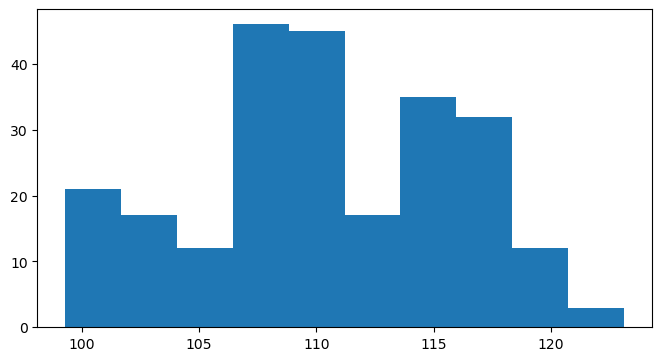

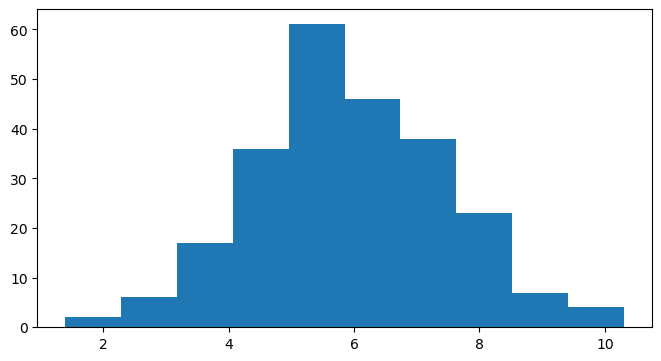

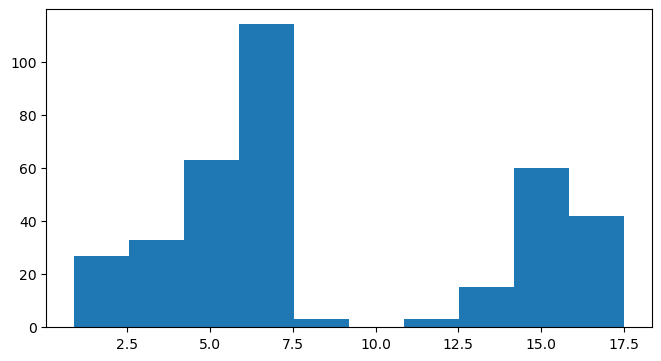

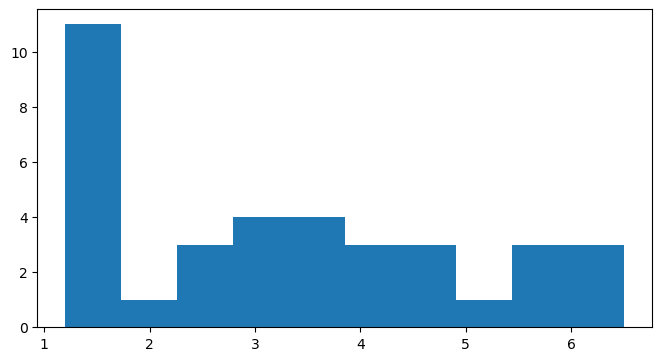

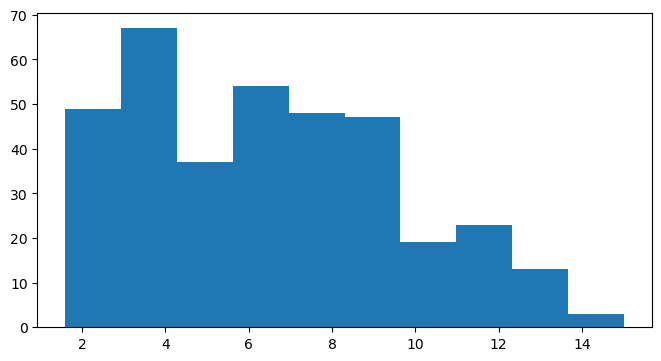

In [2]:
# Load our precalculated tensile stresses so we can just threshold the stress maps without re-training the model
with open('TensileStrengthResults_DualMap2.pickle', 'rb') as f:
    results = pickle.load(f)

# List of velocity perturbation experiment names
strain_experiments = ["Exp0", "Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6", "Exp7","Exp8", "Exp9"]
# List of covariance structure options
correlation = ["Gaussian", "Exponential"]
# List of temperature averaging options to test
temp_maps = ["Annual", "DJF", "JJA"]
# List of temperatur models to test
temp_model = ["RACMO", "MAR", "CARRA"]
# List of rate factor parameterizations to try, 0 = Cuffey & Patterson, 1 = Hooke
viscosity = [0, 1]
# List of crevasse maps
crev_maps = ["MapA", "MapB"]

delta_averaging = [];
for p in crev_maps:
    for j in temp_model:
        for k in viscosity:
            for m in strain_experiments:
                for w in correlation:
                    a = crev_maps.index(p)
                    c = temp_model.index(j)
                    d = viscosity.index(k)
                    e = strain_experiments.index(m)
                    f = correlation.index(w)
                        
                    thresh = results['err_ts'][a,:,c,d,e,f]
                    delta_averaging.append(np.max(thresh) - np.min(thresh))

delta_averaging = np.array(delta_averaging)
plt.close("all")
fig, ax = plt.subplots(layout="constrained", figsize=(6.5,3.5))
plt.hist(delta_averaging/1000)
plt.show()

delta_model = [];
for p in crev_maps:
    for i in temp_maps:
        for k in viscosity:
            for m in strain_experiments:
                for w in correlation:
                    a = crev_maps.index(p)
                    b = temp_maps.index(i)
                    d = viscosity.index(k)
                    e = strain_experiments.index(m)
                    f = correlation.index(w)
                        
                    thresh = results['err_ts'][a,b,:,d,e,f]
                    delta_model .append(np.max(thresh) - np.min(thresh))

delta_model  = np.array(delta_model )
plt.close("all")
fig, ax = plt.subplots(layout="constrained", figsize=(6.5,3.5))
plt.hist(delta_model /1000)
plt.show()

delta_viscosity = [];
for p in crev_maps:
    for i in temp_maps:
        for j in temp_model:
            for m in strain_experiments:
                for w in correlation:
                    a = crev_maps.index(p)
                    b = temp_maps.index(i)
                    e = temp_model.index(j)
                    e = strain_experiments.index(m)
                    f = correlation.index(w)
                        
                    thresh = results['err_ts'][a,b,c,:,e,f]
                    delta_viscosity.append(np.max(thresh) - np.min(thresh))

delta_viscosity = np.array(delta_viscosity)
plt.close("all")
fig, ax = plt.subplots(layout="constrained", figsize=(6.5,3.5))
plt.hist(delta_viscosity/1000)
plt.show()

delta_velocity = [];
for p in crev_maps:
    for i in temp_maps:
        for j in temp_model:
            for k in viscosity:
                    a = crev_maps.index(p)
                    b = temp_maps.index(i)
                    c = temp_model.index(j)
                    d = viscosity.index(k)
                        
                    thresh = results['err_ts'][a,b,c,d,:,:]
                    delta_velocity.append(np.max(thresh) - np.min(thresh))

delta_velocity = np.array(delta_velocity)
plt.close("all")
fig, ax = plt.subplots(layout="constrained", figsize=(6.5,3.5))
plt.hist(delta_velocity/1000)
plt.show()

delta_obs = [];
for i in temp_maps:
    for j in temp_model:
        for k in viscosity:
            for m in strain_experiments:
                for w in correlation:
                    b = temp_maps.index(i)
                    c = temp_model.index(j)
                    d = viscosity.index(k)
                    e = strain_experiments.index(m)
                    f = correlation.index(w)
                        
                    thresh = results['err_ts'][:,b,c,d,e,f]
                    delta_obs.append(np.max(thresh) - np.min(thresh))

delta_obs = np.array(delta_obs)
plt.close("all")
fig, ax = plt.subplots(layout="constrained", figsize=(6.5,3.5))
plt.hist(delta_obs/1000)
plt.show()

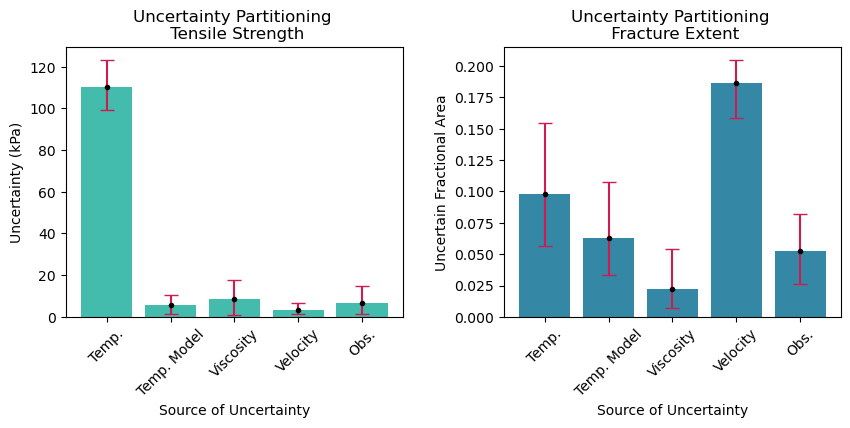

In [34]:
all_data = np.ndarray.flatten(results['err_ts'])

x = [1,2,3,4,5]
labels = ["Temp.", "Temp. Model", "Viscosity", "Velocity", "Obs."]
middle = np.array([np.mean(delta_averaging), np.mean(delta_model), np.mean(delta_viscosity), np.mean(delta_velocity), np.mean(delta_obs)])
lower = [middle[0]-np.min(delta_averaging), middle[1]-np.min(delta_model), middle[2]-np.min(delta_viscosity),middle[3]-np.min(delta_velocity),
        middle[4]-np.min(delta_obs)]
upper = [np.max(delta_averaging)-middle[0], np.max(delta_model)-middle[1], np.max(delta_viscosity)-middle[2], np.max(delta_velocity)-middle[3],
        np.max(delta_obs)-middle[4]]
asymmetric_error = np.array(list(zip(lower, upper))).T

extent = pd.read_csv("ExtentTrials2.csv")
obs = extent['error'][extent['crev_maps'] == "all"]
temp_map = extent['error'][extent['temp_maps'] == "all"]
temp_model = extent['error'][extent['temp_model'] == "all"]
velocity = extent['error'][extent['strain_experiments'] == "all"]
viscosity = extent['error'][extent['viscosity'] == "all"]

x2 = [1,2,3,4,5]
labels2 = ["Temp.", "Temp. Model", "Viscosity", "Velocity", "Obs."]
middle2 = np.array([np.mean(temp_map), np.mean(temp_model), np.mean(viscosity), np.mean(velocity), np.mean(obs)])
lower2 = [middle2[0]-np.min(temp_map), middle2[1]-np.min(temp_model), middle2[2]-np.min(viscosity), middle2[3]-np.min(velocity), middle2[4]-np.min(obs)]
upper2 = [np.max(temp_map)-middle2[0], np.max(temp_model)-middle2[1], np.max(viscosity)-middle2[2], np.max(velocity)-middle2[3], np.max(obs)-middle2[4]]
asymmetric_error2 = np.array(list(zip(lower2, upper2))).T

plt.close("all")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3.5))
ax1.bar(x, middle/1000, tick_label=labels, color="#43BBAD")
ax1.errorbar(x, middle/1000, yerr=asymmetric_error/1000, fmt='.', ecolor = "#CD1C4D", capsize=5, color='k')
ax1.set_ylabel("Uncertainty (kPa)")
ax1.set_xlabel("Source of Uncertainty")
ax1.set_xticklabels(labels, rotation=45)
ax1.set_title("Uncertainty Partitioning \n Tensile Strength")
ax2.bar(x2, middle2, tick_label=labels2, color="#3487A5")
ax2.errorbar(x2, middle2, yerr=asymmetric_error2, fmt='.', ecolor = "#CD1C4D", capsize=5, color='k')
#ax2.errorbar(x, middle/1000, yerr=asymmetric_error/1000, fmt='.', ecolor = "#CD1C4D", capsize=5, color='k')
ax2.set_ylabel("Uncertain Fractional Area")
ax2.set_xlabel("Source of Uncertainty")
ax2.set_xticklabels(labels2, rotation=45)
ax2.set_title("Uncertainty Partitioning \n Fracture Extent")
plt.subplots_adjust(wspace=0.3)
plt.savefig("C:\\Users\\rtc84\\OneDrive - Cornell University\\Research_FirstAuthor\\IceSlabCrevasses\\Revision\\RevisedFigures\\Fig6_Uncertainty_Revised.svg")
plt.show()